## Taksk 1
Create a function which calculates and returns the FIR filter **coefficients** analytically (= using **sinc** functions) for a **combined highpass and bandstop** filter. 
* The function should automatically decide how many coefficients are required. 
* The function arguments should be (a) the **sampling rate** and (b) the **cutoff frequencies**. 
* Decide which **cutoff frequencies** are needed and provide explanations by referring to the **spectra and/or fundamental frequencies** of the ECG

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def combined_highpass_bandstop_fir(sampling_rate, hp_cutoff=0.5, bs_center=50, bs_bandwidth=2):
    
    # Define Nyquist frequency and normalized cutoff
    nyquist = sampling_rate / 2
    normalized_hp_cutoff = hp_cutoff / nyquist
    
    # Calculate the high-pass filter order
    hp_transition_band = 0.5  # Example transition bandwidth
    hp_order = int(hp_transition_band / (normalized_hp_cutoff))  # Using Bt/N = (Ws - Wp) formula
    if hp_order % 2 == 0:  # Ensure order is odd for symmetry
        hp_order += 1
    highpass_coeffs = np.sinc(2 * normalized_hp_cutoff * (np.arange(hp_order) - (hp_order - 1) / 2))
    highpass_coeffs *= np.hamming(hp_order)
    highpass_coeffs = -highpass_coeffs
    highpass_coeffs[(hp_order - 1) // 2] += 1  # Make it a high-pass filter

    # Calculate the band-stop filter order
    bs_transition_band = 0.5  # Example transition bandwidth for the band-stop filter
    normalized_bs_low_cutoff = (bs_center - bs_bandwidth / 2) / nyquist
    normalized_bs_high_cutoff = (bs_center + bs_bandwidth / 2) / nyquist
    bs_order = int(bs_transition_band / (normalized_bs_high_cutoff - normalized_bs_low_cutoff))
    if bs_order % 2 == 0:
        bs_order += 1
    bandstop_coeffs = np.sinc(2 * normalized_bs_high_cutoff * (np.arange(bs_order) - (bs_order - 1) / 2)) \
                      - np.sinc(2 * normalized_bs_low_cutoff * (np.arange(bs_order) - (bs_order - 1) / 2))
    bandstop_coeffs *= np.hamming(bs_order)
    bandstop_coeffs[(bs_order - 1) // 2] += 1

    # Combine high-pass and band-stop filter coefficients by convolution
    combined_coeffs = np.convolve(highpass_coeffs, bandstop_coeffs)
    combined_coeffs /= np.sum(combined_coeffs)  # Normalize filter coefficients
    
    return combined_coeffs

## Task 2
Create an efficient Python FIR filter class which implements an FIR filter and has a method of the form value dofilter(self,value) where both the value argument and return value are scalars and not vectors (!) so that it can be used in a real-time system. The constructor of the class takes the coefficients as its input: 

>class FIRfilter: \
>def __init__(self,_coefficients): \
>your code here \
>def dofilter(self,v): \
>your code here \
>return result 

Filter both ECG recordings with the above FIR filter class using the coefficients from 1. Simulate real-time processing by feeding the ECGs sample by sample into your FIR filter class. Make sure that the ECGs look intact and that they are not distorted (PQRST intact). Provide appropriate plots in a vector-graphics format.

In [ ]:
path = 'ECG Traces-20241104/Noisy ECGs/Noisy_ECG_1000Hz_8.dat'
sampling_rate = 1000

def load_ecg_signal(filename, sampling_rate):
    try:
        ecg_signal = np.loadtxt(filename)
        return ecg_signal
    except ValueError:
        print('Error: Could not load file as text')
        return None
    
# Load ECG signal data from file
ecg_signal = load_ecg_signal(path, sampling_rate)

class FIRfilter:
    def __init__(self, coefficients):
        self.coefficients = coefficients
        self.buffer = np.zeros(len(coefficients))

    def dofilter(self, value):
        self.buffer = np.roll(self.buffer, -1)
        self.buffer[-1] = value
        result = np.dot(self.coefficients, self.buffer)
        return result


fir_coeffs = combined_highpass_bandstop_fir(sampling_rate) # Create FIR filter coefficients
FIR_filter = FIRfilter(fir_coeffs) # Initialize FIR filter with the coefficients

# Simulate real-time processing by filtering the ECG signal sample by sample
filtered_ecg_signal_realtime = np.array([FIR_filter.dofilter(sample) for sample in ecg_signal])

duration = len(ecg_signal) / sampling_rate
time = np.linspace(0, duration, len(ecg_signal))

# Plot the original and filtered signals
plt.figure(figsize=(14, 6))
plt.plot(time, ecg_signal, label='Original ECG Signal', alpha=0.6)
plt.plot(time, filtered_ecg_signal_realtime, label='Filtered ECG Signal (Real-time)', color='red', linewidth=1)
plt.legend()
plt.title('ECG Signal Before and After Real-time Filtering')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

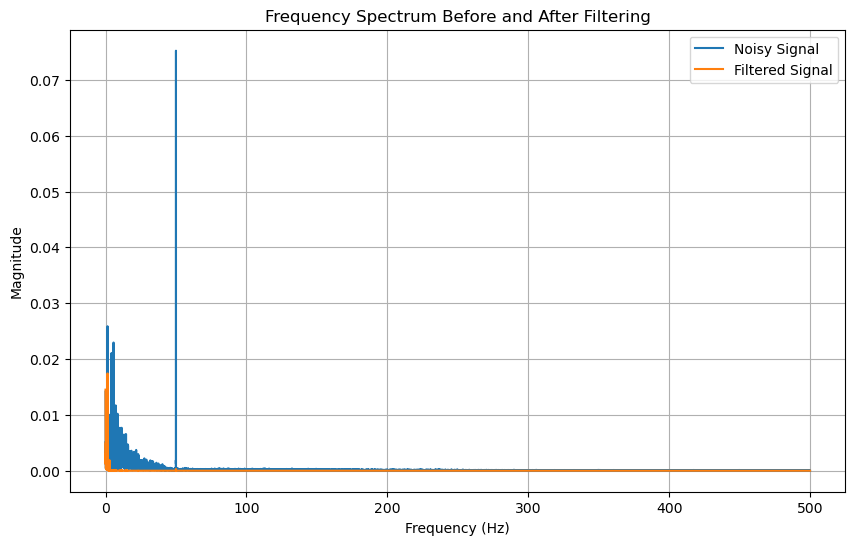

In [17]:
def plot_two_spectra(signal1, signal2, sampling_rate, title="Frequency Spectrum Comparison", plot_log=False, label1="Original Signal", label2="Filtered Signal"):
    """
    绘制两个信号的频谱图，方便比较。
    
    参数:
    - signal1: 第一个信号（时域）
    - signal2: 第二个信号（时域）
    - sampling_rate: 采样率（Hz）
    - title: 图像标题
    - plot_log: 是否绘制对数幅度谱（默认为 False，线性幅度）
    - label1: 第一个信号的标签（用于图例）
    - label2: 第二个信号的标签（用于图例）
    """
    # 计算两个信号的傅里叶变换
    fft_result1 = np.fft.fft(signal1)
    fft_result2 = np.fft.fft(signal2)
    
    n1 = len(signal1)
    n2 = len(signal2)
    
    freqs1 = np.fft.fftfreq(n1, d=1/sampling_rate)
    freqs2 = np.fft.fftfreq(n2, d=1/sampling_rate)
    
    magnitude1 = np.abs(fft_result1) / n1
    magnitude2 = np.abs(fft_result2) / n2

    # 只取正频部分
    pos_freqs1 = freqs1[:n1 // 2]
    pos_magnitude1 = magnitude1[:n1 // 2]
    
    pos_freqs2 = freqs2[:n2 // 2]
    pos_magnitude2 = magnitude2[:n2 // 2]

    # 绘图
    plt.figure(figsize=(10, 6))
    if plot_log:
        plt.plot(pos_freqs1, 20 * np.log10(pos_magnitude1 + 1e-12), label=label1)  # 避免 log(0) 错误
        plt.plot(pos_freqs2, 20 * np.log10(pos_magnitude2 + 1e-12), label=label2)
        plt.ylabel("Magnitude (dB)")
    else:
        plt.plot(pos_freqs1, pos_magnitude1, label=label1)
        plt.plot(pos_freqs2, pos_magnitude2, label=label2)
        plt.ylabel("Magnitude")

    plt.xlabel("Frequency (Hz)")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

plot_two_spectra(ecg_signal, filtered_ecg_signal_realtime, sampling_rate, 
                 title="Frequency Spectrum Before and After Filtering", 
                 plot_log=False, 
                 label1="Noisy Signal", 
                 label2="Filtered Signal")


## Task 3
Use an adaptive LMS filter to filter out DC and 50Hz by providing it with a 50Hz sine wave with DC as reference.
* Note that both the amplitudes for the 50Hz and DC references scale with the learning rate. 
* Make appropriate choices for the **amplitudes** and the **learning rate** so that both DC and 50Hz are removed. 
* Add an adaptive LMS filter method to your FIR filter class (from 2.) and name it: “doFilterAdaptive(self,signal,noise,learningRate)” which returns the cleaned up ECG. 
* As before also this function must receive only scalars (i.e. sample by sample) and return a scalar. Plot and compare the result from the adaptive filter and that from the FIR filter design.

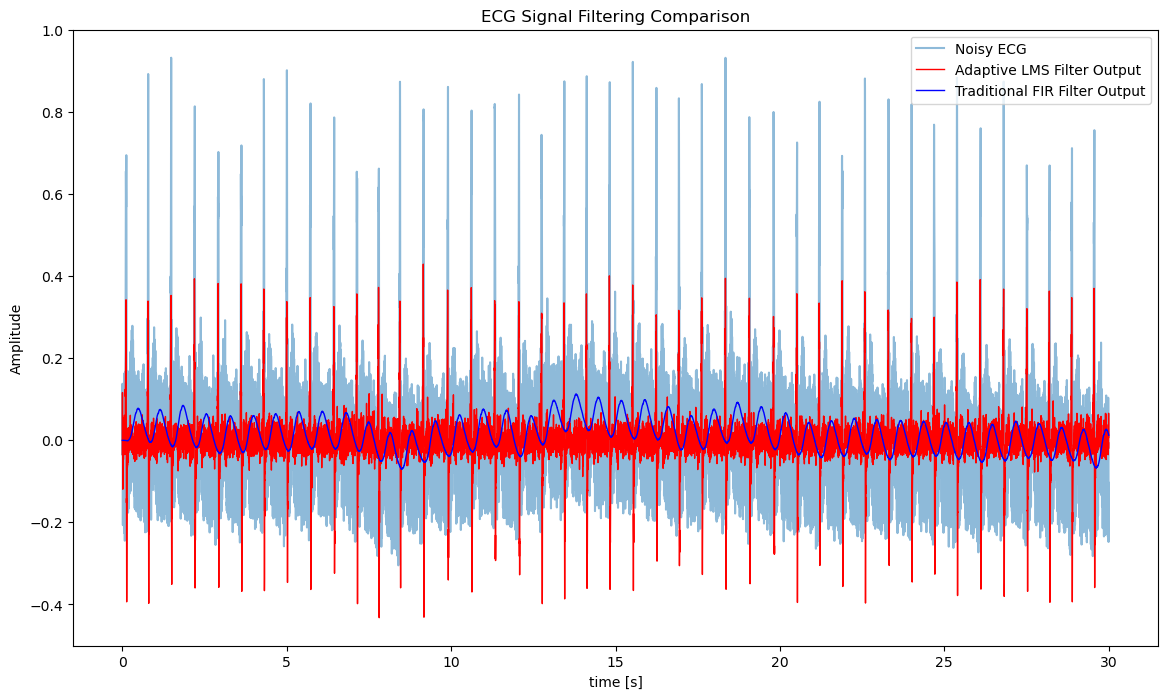

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def load_ecg_signal(filename, sampling_rate):
    try:
        ecg_signal = np.loadtxt(filename)
        return ecg_signal
    except ValueError:
        print('Error: Could not load file as text')
        return None

# Function to generate 50Hz reference signal with DC
def generate_reference_signals(sample_index, sampling_rate):
    dc_component = 1.0  # Constant for DC reference
    sin_50hz = np.sin(2 * np.pi * 50 * sample_index / sampling_rate)
    return dc_component, sin_50hz


class FIRFilter:
    def __init__(self, coefficients):
        self.coefficients = coefficients
        self.buffer = np.zeros(len(coefficients))  # Initialize the buffer for FIR filtering

    def dofilter(self, value):
        self.buffer = np.roll(self.buffer, -1)
        self.buffer[-1] = value
        result = np.dot(self.coefficients, self.buffer)
        return result

    def doFilterAdaptive(self, signal, referance_signal, learningRate):
               
        if not hasattr(self, 'weights'):
            self.weights = np.zeros(2)  # Initialize filter weights

        dc_reference, sine_50hz = referance_signal 
        
        reference = np.array([dc_reference, sine_50hz])
        
        # Calculate the output of the adaptive filter (dot product of weights and reference)
        adaptive_output = np.dot(self.weights, reference)
        
        # Calculate the error between the desired signal (signal) and the filter output
        error = signal - adaptive_output
        
        # Update weights using LMS rule: w = w + 2 * learningRate * error * reference
        self.weights += 2 * learningRate * error * reference
        
        return error  # The filtered output is the error


# Load ECG signal data fpath = 'ECG Traces-20241104/Noisy ECGs/Noisy_ECG_1000Hz_8.dat'rom file

sampling_rate = 1000
ecg_signal = load_ecg_signal(path, sampling_rate)

learning_rate = 0.05 # Learning rate for the LMS algorithm

# Instantiate the FIR filter
fir_filter = FIRFilter(coefficients=np.ones(20) / 20)


# Adaptive filtering with LMS
adaptive_output = []

for n, sample in enumerate(ecg_signal):
    # Generate reference signals for the current sample
    dc_ref, sine_50hz_ref = generate_reference_signals(n, sampling_rate)
    
    # Adaptive filter output
    filtered_sample_adaptive = fir_filter.doFilterAdaptive(sample, (dc_ref, sine_50hz_ref), learning_rate)
    adaptive_output.append(filtered_sample_adaptive)
    

# Convert to numpy arrays for plotting
adaptive_output = np.array(adaptive_output)

duration = len(ecg_signal) / sampling_rate
time = np.linspace(0, duration, len(ecg_signal))

# Plot the original noisy ECG, adaptive filter output, and FIR filter output
plt.figure(figsize=(14, 8))
plt.plot(time, ecg_signal, label='Noisy ECG', alpha=0.5)
plt.plot(time, adaptive_output, label='Adaptive LMS Filter Output', color='red', linewidth=1)
plt.plot(time, filtered_ecg_signal_realtime, label='Traditional FIR Filter Output', color='blue', linewidth=1)
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('Amplitude')
plt.title('ECG Signal Filtering Comparison')
plt.show()


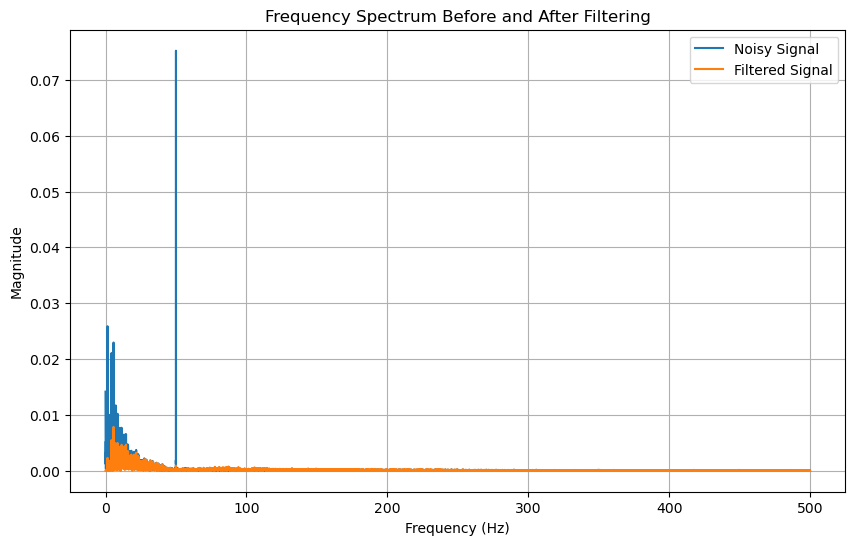

In [16]:
def plot_two_spectra(signal1, signal2, sampling_rate, title="Frequency Spectrum Comparison", plot_log=False, label1="Original Signal", label2="Filtered Signal"):
    """
    绘制两个信号的频谱图，方便比较。
    
    参数:
    - signal1: 第一个信号（时域）
    - signal2: 第二个信号（时域）
    - sampling_rate: 采样率（Hz）
    - title: 图像标题
    - plot_log: 是否绘制对数幅度谱（默认为 False，线性幅度）
    - label1: 第一个信号的标签（用于图例）
    - label2: 第二个信号的标签（用于图例）
    """
    # 计算两个信号的傅里叶变换
    fft_result1 = np.fft.fft(signal1)
    fft_result2 = np.fft.fft(signal2)
    
    n1 = len(signal1)
    n2 = len(signal2)
    
    freqs1 = np.fft.fftfreq(n1, d=1/sampling_rate)
    freqs2 = np.fft.fftfreq(n2, d=1/sampling_rate)
    
    magnitude1 = np.abs(fft_result1) / n1
    magnitude2 = np.abs(fft_result2) / n2

    # 只取正频部分
    pos_freqs1 = freqs1[:n1 // 2]
    pos_magnitude1 = magnitude1[:n1 // 2]
    
    pos_freqs2 = freqs2[:n2 // 2]
    pos_magnitude2 = magnitude2[:n2 // 2]

    # 绘图
    plt.figure(figsize=(10, 6))
    if plot_log:
        plt.plot(pos_freqs1, 20 * np.log10(pos_magnitude1 + 1e-12), label=label1)  # 避免 log(0) 错误
        plt.plot(pos_freqs2, 20 * np.log10(pos_magnitude2 + 1e-12), label=label2)
        plt.ylabel("Magnitude (dB)")
    else:
        plt.plot(pos_freqs1, pos_magnitude1, label=label1)
        plt.plot(pos_freqs2, pos_magnitude2, label=label2)
        plt.ylabel("Magnitude")

    plt.xlabel("Frequency (Hz)")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

plot_two_spectra(ecg_signal, adaptive_output, sampling_rate, 
                 title="Frequency Spectrum Before and After Filtering", 
                 plot_log=False, 
                 label1="Noisy Signal", 
                 label2="Filtered Signal")


## Task 4
ECG heartbeat detection: The task is to detect R-peaks in the noisy ECG recording. Use the FIR filter from 2. as a matched filter and use an R-peak as a template from the noise-free ECG. Plot the momentary heart rate (i.e. inverse intervals between R-peaks) against time. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 手动实现 FIR 滤波
def apply_fir_filter(signal, filter_coeffs):
    filtered_signal = np.zeros(len(signal))
    for i in range(len(filter_coeffs), len(signal)):
        filtered_signal[i] = np.dot(signal[i - len(filter_coeffs):i], filter_coeffs[::-1])
    return filtered_signal

# 手动实现峰值检测
def detect_peaks(signal, threshold, refractory_period, sampling_rate):
    peaks = []
    last_peak = -refractory_period * sampling_rate
    for i in range(len(signal)):
        if signal[i] > threshold and (i - last_peak) > refractory_period * sampling_rate:
            peaks.append(i)
            last_peak = i
    return np.array(peaks)

# 加载 ECG 信号
def load_ecg_signal(filename):
    try:
        ecg_signal = np.loadtxt(filename)
        return ecg_signal
    except ValueError:
        print("Error: Could not load file as text")
        return None

# 参数设置
sampling_rate = 1000  # 采样率 (Hz)
refractory_period = 0.2  # 不应期 (秒)
threshold_multiplier = 0.6  # 阈值乘数

# 加载干净和带噪声的 ECG 信号
clean_ecg = load_ecg_signal('ECG Traces-20241104/Lying ECGs/Lying_ECG_1000Hz_8.dat')
noisy_ecg = load_ecg_signal('ECG Traces-20241104/Noisy ECGs/Noisy_ECG_1000Hz_8.dat')

# 检查文件是否成功加载
if clean_ecg is None or noisy_ecg is None:
    raise RuntimeError("Error: Unable to load ECG signals")

# 时间向量
duration = len(noisy_ecg) / sampling_rate
time = np.linspace(0, duration, len(noisy_ecg))

# 提取 R 波模板
template_length = int(0.2 * sampling_rate)  # 假设 R 波持续 ~200ms
template = clean_ecg[:template_length]

# 创建匹配滤波器
matched_filter = template / np.linalg.norm(template)  # 归一化模板

# 应用匹配滤波器
filtered_ecg = apply_fir_filter(noisy_ecg, matched_filter)

# 手动检测 R 峰
threshold = threshold_multiplier * np.max(filtered_ecg)
peaks = detect_peaks(filtered_ecg, threshold, refractory_period, sampling_rate)

# 计算心率
r_intervals = np.diff(peaks) / sampling_rate  # R-R 间隔 (秒)
heart_rate = 60 / r_intervals  # 心率 (BPM)
time_hr = peaks[1:] / sampling_rate  # 心率对应的时间点

# 绘图
plt.figure(figsize=(12, 8))

# 绘制带噪声 ECG 信号和检测到的 R 峰
plt.subplot(2, 1, 1)
plt.plot(time, noisy_ecg, label="Noisy ECG")
plt.plot(peaks / sampling_rate, noisy_ecg[peaks], "rx", label="Detected R-peaks")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Noisy ECG with Detected R-peaks")
plt.legend()

# 绘制瞬时心率
plt.subplot(2, 1, 2)
plt.plot(time_hr, heart_rate, label="Heart Rate (BPM)")
plt.xlabel("Time (s)")
plt.ylabel("Heart Rate (BPM)")
plt.title("Momentary Heart Rate")
plt.legend()

plt.tight_layout()
plt.show()